<a href="https://colab.research.google.com/github/alexlyk93/alexlyk93.github.io/blob/master/Scraping_TVs_info_from_ecommerce_site.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OBTAIN DATA**

In [1]:
from bs4 import BeautifulSoup
import requests
import re

In [2]:
links = []

#looping all pages
for i in range(5):
  url = "https://www.senheng.com.my/home-entertainment/tv.html?p={}".format(i)
  r = requests.get(url)
  soup = BeautifulSoup(r.content,'html')
  results = soup.find_all('div',{'class':'product-item-info'})
  for result in results:
    links.append(result.a['href'])

In [3]:
all_list = []

#looping all link and extract product info
for link in links:
  content = {}
  page_respone = requests.get(link)
  page_content = BeautifulSoup(page_respone.content,'html')
  content['Title'] = page_content.select('h1')[0].text.strip()
  content['Stock'] = page_content.find_all('div',{'title':'Availability'})[0].text.strip()
  content['Link'] = link

  try:
    content['Warranty'] = page_content.find_all('div',{'itemprop':'warranty'})[0].text.strip()
  except IndexError:
    content['Warranty'] = ""

  try:
    content['Display_format'] = page_content.find_all('li',{'class':'item 4'})[0].text.strip()
  except:
    content['Display_format'] = ''

  try:
    content['Current_price (RM)'] = page_content.find_all('span',{'class':'price'})[0].text.strip()
  except:
    content['Current_price (RM)'] = ''

  try:
    content['Original_price (RM)'] = page_content.find_all('span',{'class':'old-price'})[0].text.strip()
  except:
    content['Original_price (RM)'] = ''

  try:
    content['Rating'] = page_content.find_all('a',{'class':'nobr'})[0].text.split()[0]
  except:
    content['Rating'] = ''

  try:
    content['Inch'] = page_content.find_all('td',{'data-th':'TV Screen Size (inch)'})[0].text.strip()
  except:
    content['Inch'] = ''

  try:
    content['Qty'] = int(page_content.find_all('span',{'itemprop':'reviewCount'})[0].text.strip())
  except:
    content['Qty'] = 0

  all_list.append(content)


In [4]:
#check the output
all_list[:2]

[{'Current_price (RM)': 'RM9,899.00',
  'Display_format': 'QLED TVs',
  'Inch': '60 - 69 Inches',
  'Link': 'https://www.senheng.com.my/samsung-65-inch-q80t-qled-4k-uhd-hdr-smart-tv-sam-qa65q80ta.html',
  'Original_price (RM)': 'RM10,999.00',
  'Qty': 0,
  'Rating': '',
  'Stock': 'In stock',
  'Title': 'Samsung 65 Inch Q80T QLED 4K UHD HDR Smart TV SAM-QA65Q80TA',
  'Warranty': '2-Years Warranty'},
 {'Current_price (RM)': 'RM14,999.00',
  'Display_format': 'UHD TVs',
  'Inch': '80 Inches and above',
  'Link': 'https://www.senheng.com.my/sharp-aquos-80-inch-4k-uhd-android-tv-4tc80cl1x.html',
  'Original_price (RM)': 'RM21,999.00',
  'Qty': 0,
  'Rating': '',
  'Stock': 'In stock',
  'Title': 'Sharp AQUOS 80 Inch 4K UHD Android TV 4TC80CL1X',
  'Warranty': '2-Years Warranty'}]

# **CLEAN DATA**

In [5]:
import pandas as pd

#convert dictionery into dataframe
df = pd.DataFrame(all_list)

In [6]:
df['Brand'] = df['Title'].str.split().str[0]

#split to two dataframe, with value and without value
_a = df[df['Inch'] == '']
_b = df[df['Inch'] != '']

In [7]:
_a['Inch'] = df['Title'].str.split().str[1]
_a.loc[_a['Title'] == 'Samsung Q60T QLED 4K UHD HDR Smart TV 2020' ,'Inch'] = '65'
_a.loc[_a['Title'] == 'Sharp 8K Resolution TV SHP-8TC80AX1X' ,'Inch'] = '80'
_a.loc[_a['Title'] == 'Samsung Q60T QLED 4K UHD HDR Smart TV 2020-75 Inches' ,'Inch'] = '75'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
#replace size
_a['Inch'] = _a['Inch'].str[:1]
mappings = {'3':'39 Inches & Below','4':'40 - 49 Inches','5':'50 - 59 Inches','6':'60 - 69 Inches','7':'70 - 79 Inches','8':'80 Inches and above'}
_a['Inch'] = _a['Inch'].replace(mappings)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
#drop computer's monitor
computer_index = _a[_a['Inch'] == '2'].index
_a = _a.drop(computer_index)

In [10]:
#join dataframe
final = pd.concat([_a,_b])

In [11]:
#remove unwanted symbol
final['Current_price (RM)'] = final['Current_price (RM)'].str[2:-3]
final['Original_price (RM)'] = final['Original_price (RM)'].str[2:-3]

final['Current_price (RM)'] = final['Current_price (RM)'].str.replace('[^\w\s]','')
final['Original_price (RM)'] = final['Original_price (RM)'].str.replace('[^\w\s]','')

#convert to interger
final[['Current_price (RM)','Original_price (RM)']] = final[['Current_price (RM)','Original_price (RM)']].astype('int')

In [12]:
#replace missing data
final.loc[final['Warranty']=='','Warranty'] = 'Without Warranty'
final.loc[(final['Brand']=='Sharp') & (final['Display_format'] == ''),'Display_format'] = 'UHD TVs'
final.loc[(final['Brand']=='LG') & (final['Display_format'] == ''),'Display_format'] = 'NanoCell TVs'
final.loc[(final['Brand']=='Sony') & (final['Display_format'] == ''),'Display_format'] = 'Others'

In [13]:
#save to csv file / download csv file
final.to_csv("tv_info_data.csv")
from google.colab import files
files.download("tv_info_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **EXPLORE DATA**

In [14]:
%matplotlib inline 

import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 

sns.set()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of TV')

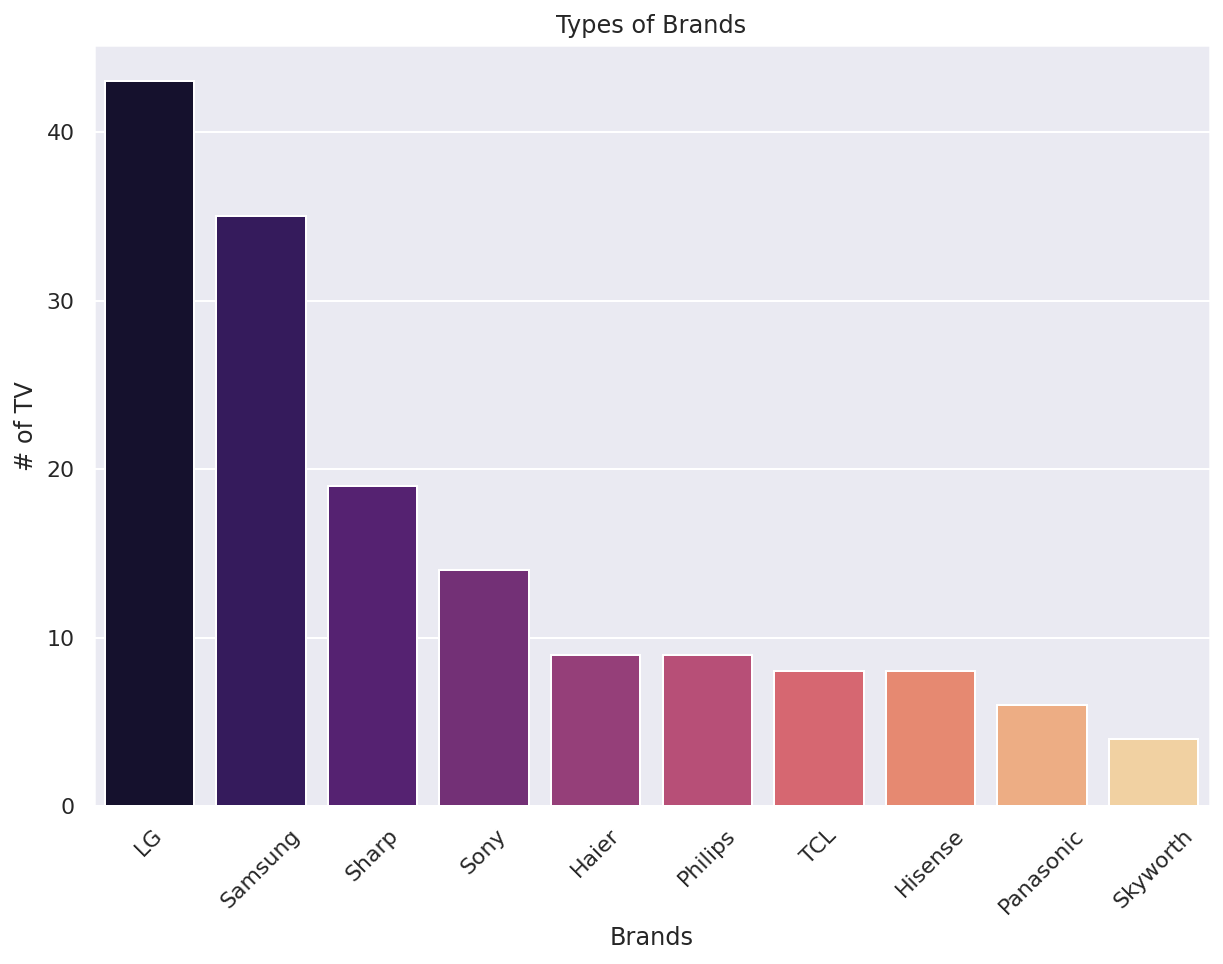

In [15]:
plt.figure(figsize=(10,7))
ax = sns.countplot(final['Brand'], order =final['Brand'].value_counts().index,palette = 'magma')
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=45)
plt.title('Types of Brands')
plt.xlabel('Brands')
plt.ylabel('# of TV')

---
There are 10 brands of TV carried by this ecommerce shop. LG and Samsung are the popular brands, follow by Sony and Sharp.

---


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of TV')

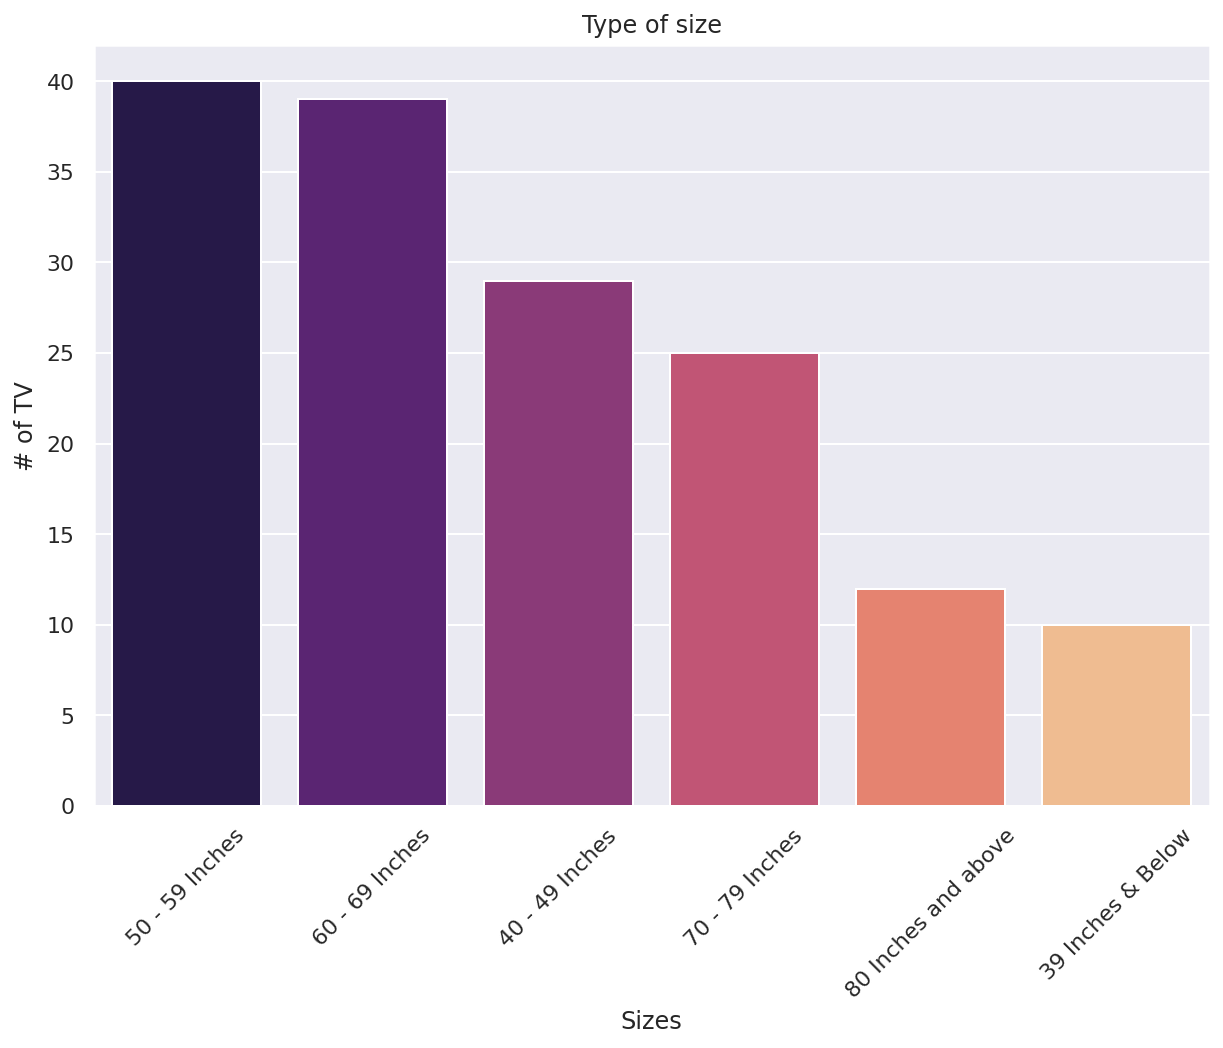

In [16]:
plt.figure(figsize=(10,7))
ax = sns.countplot(final['Inch'], order =final['Inch'].value_counts().index,palette = 'magma')
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=45)
plt.title('Type of size')
plt.xlabel('Sizes')
plt.ylabel('# of TV')

---
Size of TVs carried by this ecommerce shop is vary. Size with 80 inch and above and 39 inches and below are less carried.

---

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of TV')

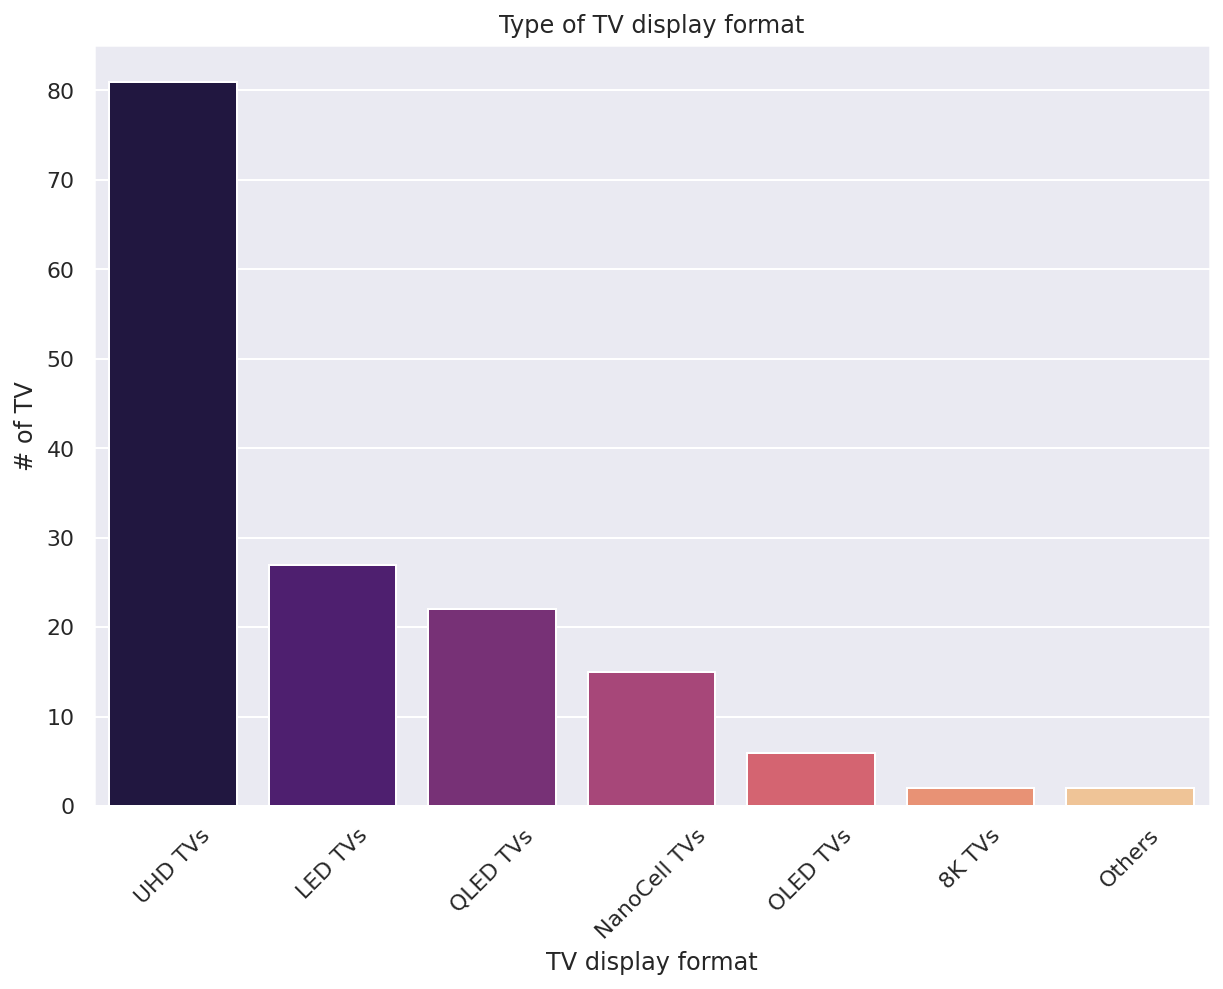

In [17]:
plt.figure(figsize=(10,7))
ax = sns.countplot(final['Display_format'], order =final['Display_format'].value_counts().index,palette = 'magma')
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=45)
plt.title('Type of TV display format')
plt.xlabel('TV display format')
plt.ylabel('# of TV')

---
UHD TVs display format are the hottest product in this ecommerce shop. 

---

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of TV')

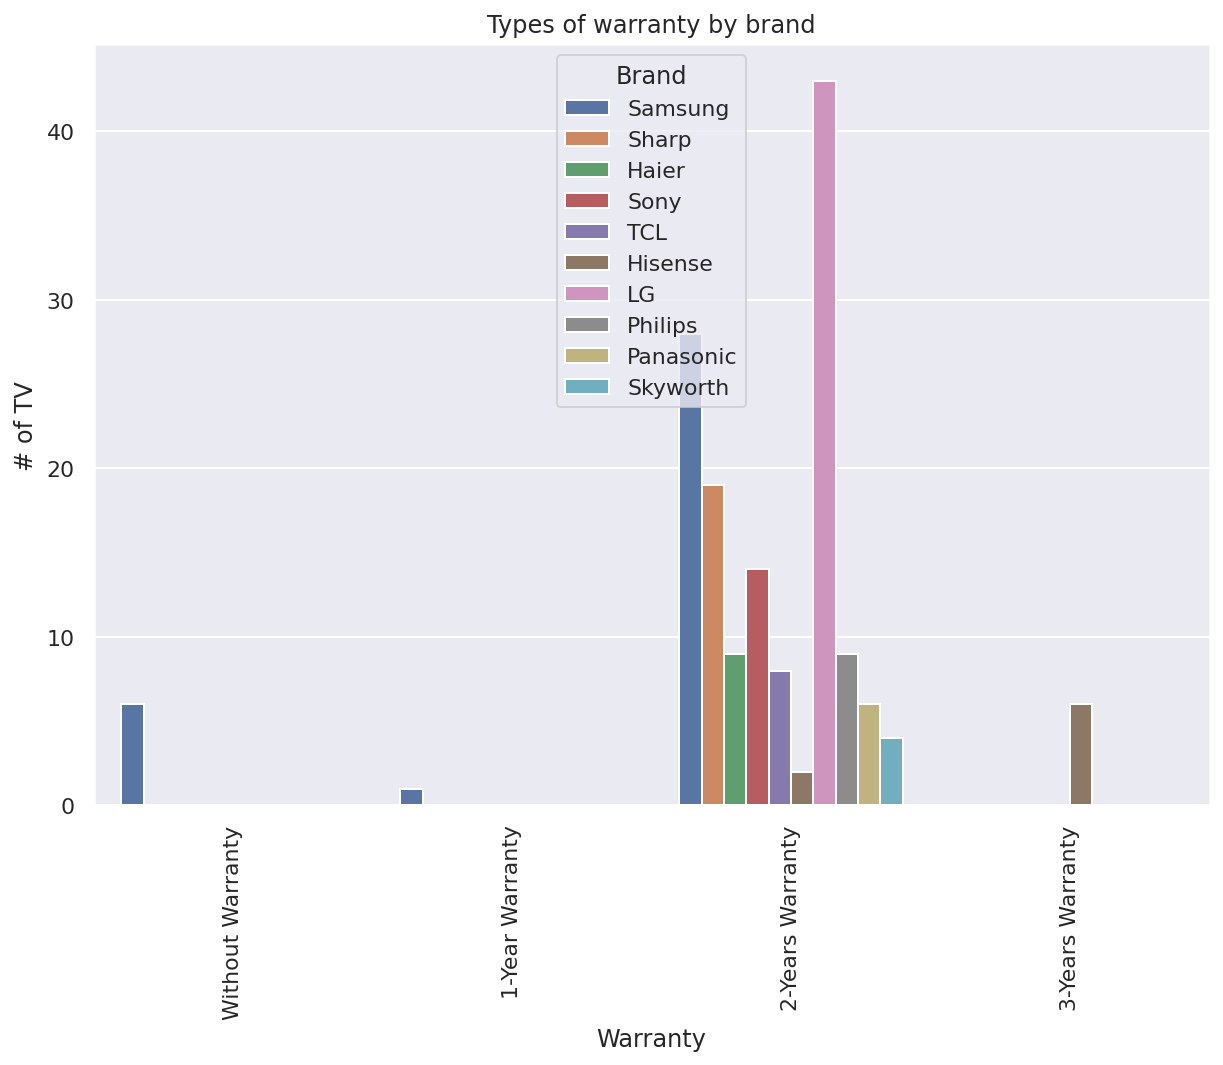

In [18]:
plt.figure(figsize=(10,7))
orders = ['Without Warranty','1-Year Warranty','2-Years Warranty','3-Years Warranty']
ax = sns.countplot(final['Warranty'], data=final, order =orders, hue=final['Brand'])
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)
plt.title('Types of warranty by brand')
plt.xlabel('Warranty')
plt.ylabel('# of TV')

---
Majority brands offered 2 year of product warranty. Hisense brands offered up to 3 years of warranty.

---

Brand
LG           104
Samsung       50
Sony           2
Sharp          2
Philips        1
Haier          1
TCL            0
Skyworth       0
Panasonic      0
Hisense        0
Name: Qty, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

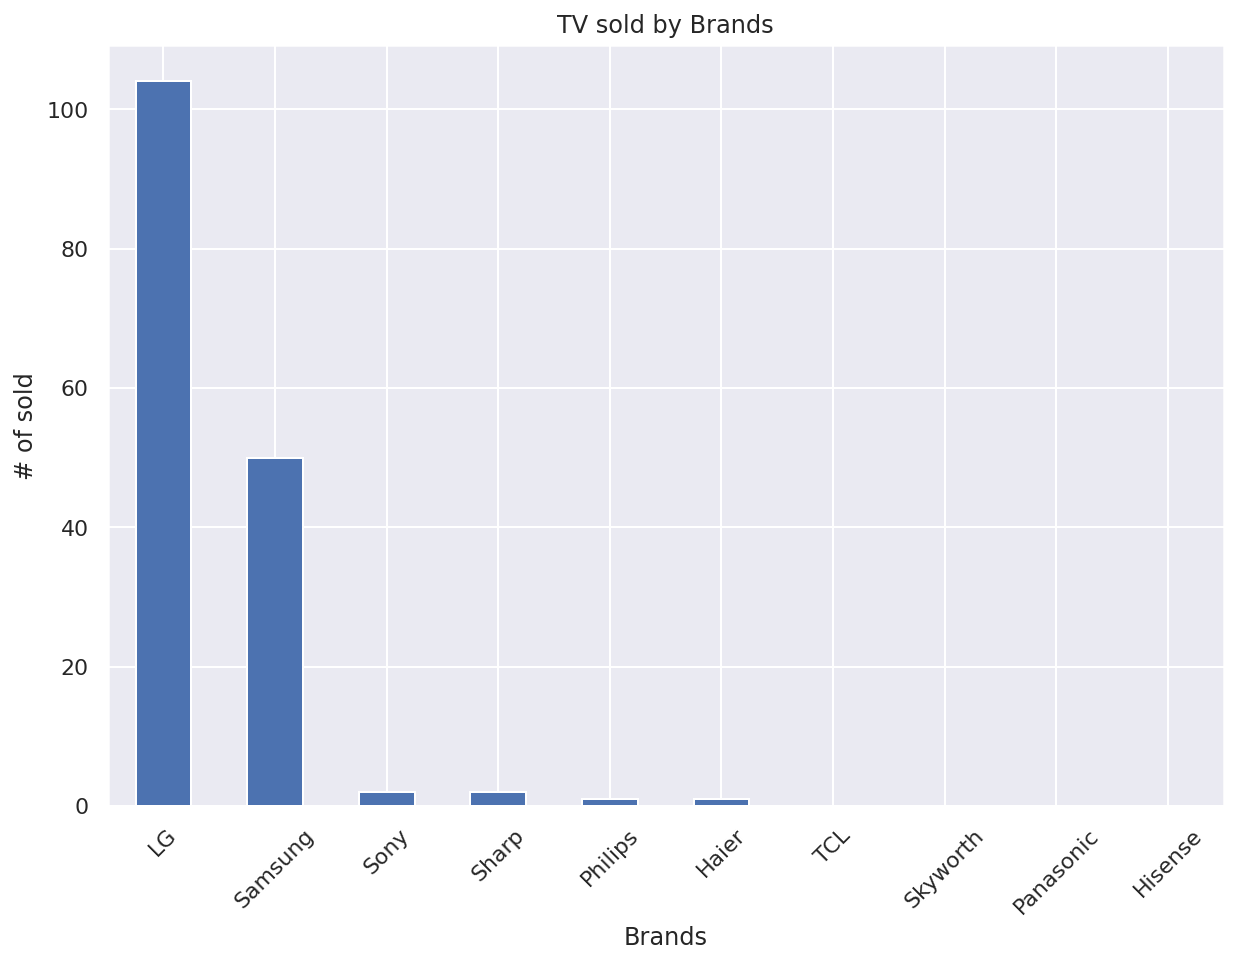

In [19]:
plt.figure(figsize=(10,7))
brands = final.groupby('Brand')['Qty'].sum().sort_values(ascending=False).plot(kind='bar')
print(final.groupby('Brand')['Qty'].sum().sort_values(ascending=False))
plt.title('TV sold by Brands')
plt.xlabel('Brands')
plt.ylabel('# of sold')
plt.xticks(rotation=45)

---
Customer are more favorable to LG and Samsung brands. There are 98 units of LG and 40 units of Samsung TVs being sold out.

---

This bar chart show the customer purchase towards those brand. The trend are similiar with the brands carried by this online shop.

Inch
50 - 59 Inches         82
60 - 69 Inches         41
40 - 49 Inches         29
70 - 79 Inches          6
80 Inches and above     2
39 Inches & Below       0
Name: Qty, dtype: int64


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

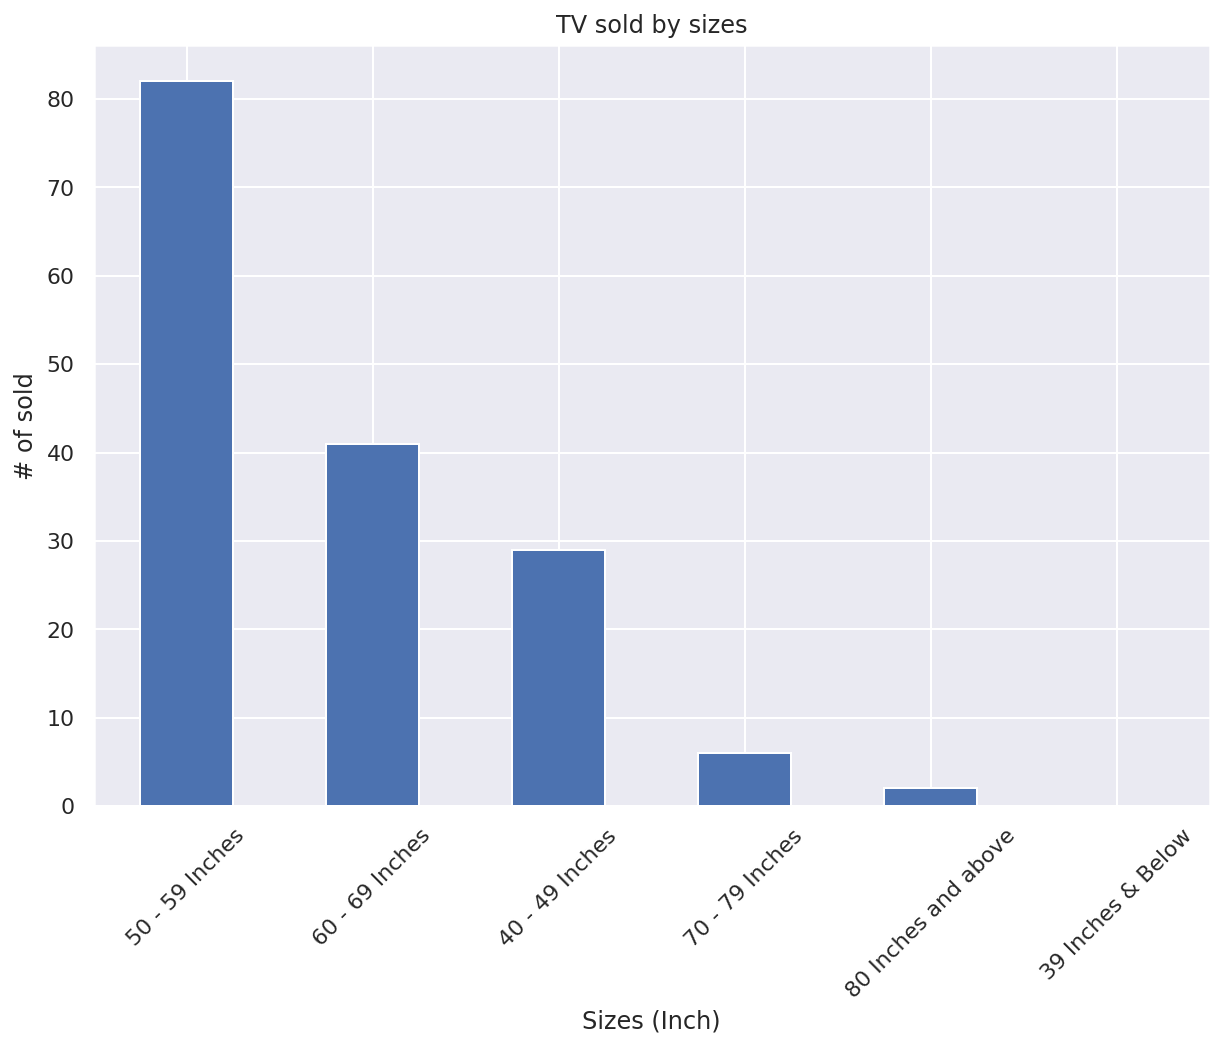

In [20]:
plt.figure(figsize=(10,7))
size_inch = final.groupby('Inch')['Qty'].sum().sort_values(ascending=False).plot(kind='bar')
print(final.groupby('Inch')['Qty'].sum().sort_values(ascending=False))
plt.title('TV sold by sizes')
plt.xlabel('Sizes (Inch)')
plt.ylabel('# of sold')
plt.xticks(rotation=45)

---
There are three category of TV popular size. Majority customer looking for sizes within 40 and 69 inches. 

---

Display_format
UHD TVs         135
NanoCell TVs     15
QLED TVs          5
LED TVs           2
8K TVs            2
Others            1
OLED TVs          0
Name: Qty, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

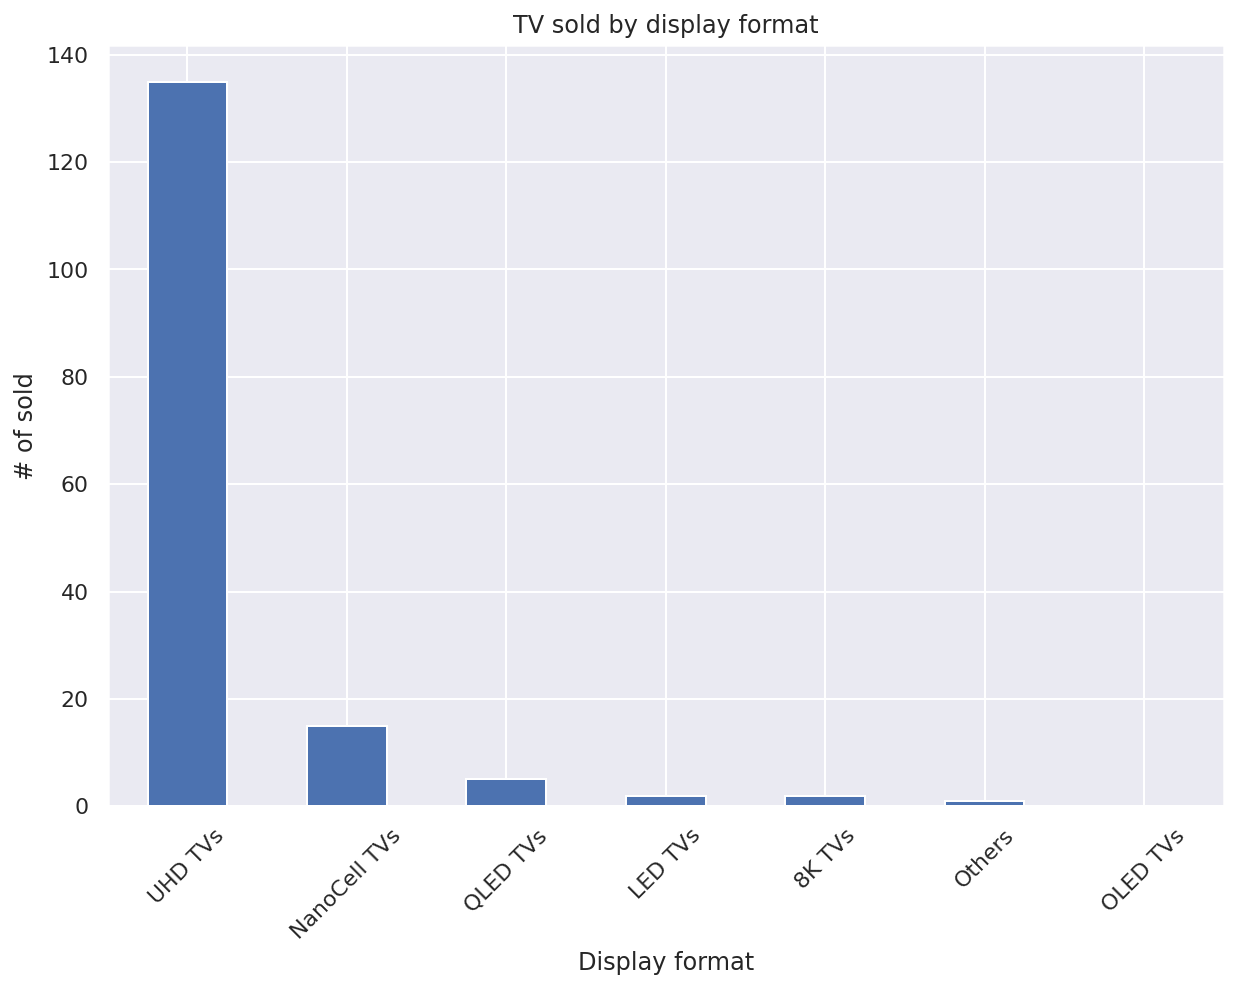

In [21]:
plt.figure(figsize=(10,7))
dis_for = final.groupby('Display_format')['Qty'].sum().sort_values(ascending=False).plot(kind='bar')
print(final.groupby('Display_format')['Qty'].sum().sort_values(ascending=False))
plt.title('TV sold by display format')
plt.xlabel('Display format')
plt.ylabel('# of sold')
plt.xticks(rotation=45)

---
UHD TVs display format are the technology accepted by most customer. 

---

In [22]:
rate = final[final['Rating'] != ''].groupby('Rating').agg({'Brand':'count'})
rate

,Brand
Rating,
1,1
4,2
4.3,1
4.5,2
4.8,3
5,45


---
# **Conclusion**:

-There are 10 brands of TV carried by this ecommerce shop. LG and Samsung 
are the most popular brands, follow by Sony and Sharp. LG brands was the best selling which there were 98 unit selling out, while Samsung was the 2nd best selling which there were 40 unit sold.

-Those TV size of 39 inches & below as well as 80 inches & above are not hot selling TV. Customer are prefer size within 40 to 69 inches

-In current trend, people are more favor to UHD TVs where there are 121 units sold out.

-Most brands offer 2 years of warranty. There are some Samsung model offer 1 year of warranty and Hisense brands offer up to 3 years warranty.

-The ratings from customer mostly is avaerage of 5 stars, majority of them giving high star. While there is one customer given 1 star. In order to analysis the those customer feedback, we can further study by doing sentiment analysis.

-The trend of brand carried versus sold out are quite similiar, those with high number of carried are the hot sell item. 


*   Advice to owner: Keep minimum stock level for not famous brand or sell out as soon as possible which may reduce the storage cost as well as fasten the company cash flow.
*   Advice to followers/competitors: Study the trend or pattern to strategies their business plan or set up price to stay competitive.

**Limitation:**

-Further analysis can be done with customer dataset to understand their browsing behaviour.

---